In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [51]:
import os
import pickle
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import lsq_linear
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

%pwd

'/home/naodell/work/hgcal/ECONAutoencoderStudy/notebooks'

129.105.21.247:8008/## Configuration

### Plotting styling

In [52]:
matplotlib.rcParams.update({'font.size': 18})

colors = dict(
      Threshold0 = 'black',
      Mixedbcstc = 'black',
      AutoEncoderStrideTelescope = 'tab:orange',
      AutoEncoderStrideTelescopeEle = 'tab:blue',
)

styles = dict(
              Threshold0 = '-',
              Mixedbcstc = '--',
              AutoEncoderStrideTelescope = '-',
              AutoEncoderStrideTelescopeEle = '-'
             )

legends = dict(
         Threshold0 = 'All TC',
         Mixedbcstc = 'BC+STC',
         AutoEncoderStrideTelescope = 'AE Stride',
         AutoEncoderStrideTelescopeEle = 'AE Stride (ele)'
        )

ref_name = 'Threshold0'
plotted_algo = ['Threshold0',
                'Mixedbcstc',
                'AutoEncoderStrideTelescope', 
                'AutoEncoderStrideTelescopeEle', 
               ]

### Input files and FE algorithms to be studied
Both 200PU electron gun and 0PU photon guns are loaded

In [69]:
version = 'updated'
fig_dir = 'img/electron_photon_calib_autoencoder_{}'.format(version)
algo_files = {}

# Read  first set
directory = '/home/naodell/work/hgcal/ECONAutoencoderStudy/data/test_20220214_155316'
files = dict(electron = glob(f'{directory}/output_electrons_*'), photon =  glob(f'{directory}/output_photons_nopu_*'))

fes = ['Threshold0', 'Mixedbcstc', 'AutoEncoderStrideTelescope', 'AutoEncoderStrideTelescopeEle']

## Loading and preprocessing dataframes

In [72]:
pt_cut = 5
dr_cut = 0.05
clpt_cut = 5
eta_min = 1.6
eta_max = 2.9
gen_selection = f'(genpart_pt > {pt_cut}) and (abs(genpart_exeta) > {eta_min}) and (abs(genpart_exeta) < {eta_max})'
cl_selection = f'(cl3d_pt > {clpt_cut}) and (abs(cl3d_eta) > {eta_min}) and (abs(cl3d_eta) < {eta_max}) \
                 and (matched_dr < {dr_cut}) and (matched_dr != -1)'

dict_df_electron = {fe:[] for fe in fes}
dict_df_photon = {fe:[] for fe in fes}
for filename in tqdm(files['electron'], desc='loading electron dataframes'):
    postfix = filename.split('.')[-1]
    if postfix == 'hdf5':
        store = pd.HDFStore(filename, mode='r')
    elif postfix == 'pkl':
        file = open(filename, mode='rb') 
        store = pickle.load(file)
                 
    for fe in fes:
        df = store[fe]
        if fe == 'gen':
            df.query(gen_selection, inplace=True)
        else:
            df.query(cl_selection, inplace=True)

        dict_df_electron[fe].append(df)
                 
    if postfix == 'hdf5':
        store.close()
    elif postfix == 'pkl':
        file.close()
    
for filename in tqdm(files['photon'], desc='loading photon dataframes'):
    postfix = filename.split('.')[-1]
    if postfix == 'hdf5':
        store = pd.HDFStore(filename, mode='r')
    elif postfix == 'pkl':
        file = open(filename, mode='rb') 
        store = pickle.load(file)
                 
    for fe in fes:
        df = store[fe]
        if fe == 'gen':
            df.query(gen_selection, inplace=True)
        else:
            df.query(cl_selection, inplace=True)

        dict_df_photon[fe].append(df)
                 
    if postfix == 'hdf5':
        store.close()
    elif postfix == 'pkl':
        file.close()
        
#for algo, df_list in df_dict_electron.items():
#    df = pd.concat(df_list)
#    df_dict_electron[algo] = df
#    
#for algo, df_list in df_dict_photon.items():
#    df = pd.concat(df_list)
#    df_dict_photon[algo] = df
 
dict_df_electron = {algo:pd.concat(df_list) for algo, df_list in dict_df_electron.items()}
dict_df_photon = {algo:pd.concat(df_list) for algo, df_list in dict_df_photon.items()}

loading electron dataframes:   0%|          | 0/28 [00:00<?, ?it/s]

loading photon dataframes:   0%|          | 0/3 [00:00<?, ?it/s]

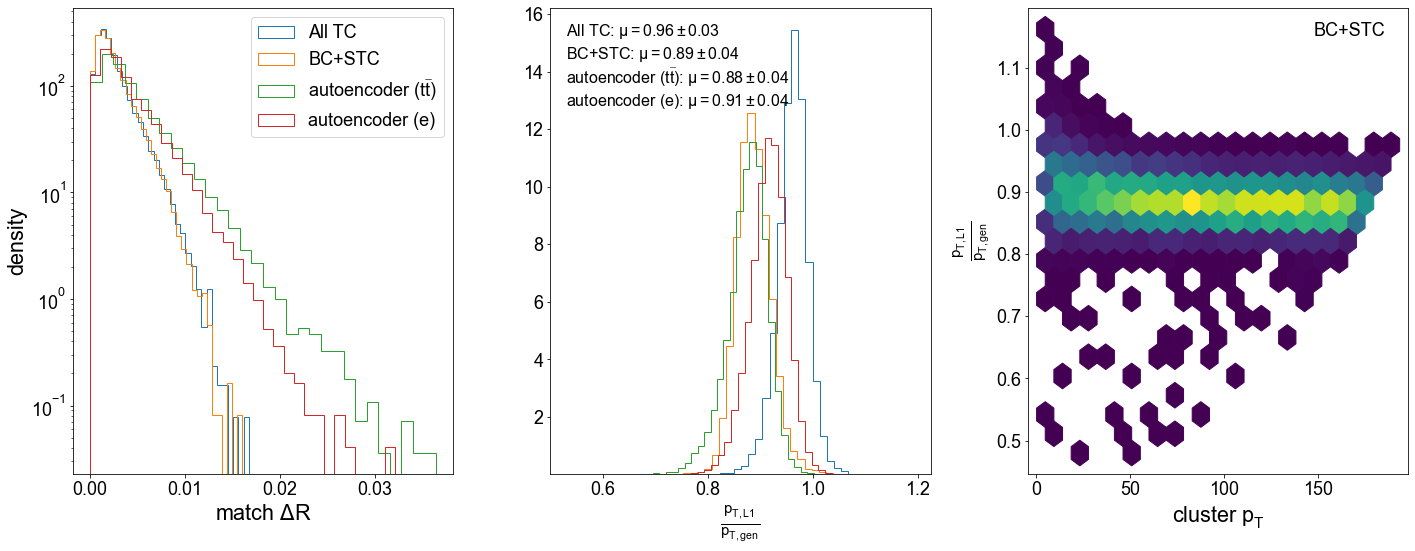

In [73]:
# make some preliminary plots showing layer-by-layer pt modeling w/o corrections

fig, axes = plt.subplots(1, 3, figsize=(20, 8), facecolor='white')
fancy_labels = ['All TC', 'BC+STC', r'autoencoder ($t\bar{t}$)', r'autoencoder (e)']
pt_bins = np.arange(5, 200, 10)

for i, fe in enumerate(fes):
    if fe == 'gen': continue
    
    df_photons = dict_df_photon[fe].query('(matched_pid == 22) and (matched_pt > 5) and (abs(matched_dr) < 0.05)')
    #df_photons['pt_bins'] = pd.cut(
    cl3d_pt = df_photons['cl3d_pt']

    ax = axes[0]
    ax.hist(df_photons['matched_dr'], bins=30, histtype='step', density=True)
    ax.set_xlabel(r'match $\Delta R$')
    ax.set_ylabel('density')
    ax.set_yscale('log')
    #ax.set_ylim(0.1, None)
    #ax.scatter(x, layer_pt_norm)

    ax = axes[1]
    ratio_pt = cl3d_pt/df_photons['matched_pt']
    ax.hist(ratio_pt, bins=50, histtype='step', density=True)
    ax.set_xlabel(r'$\frac{p_{T, L1}}{p_{T, gen}}$')
    ax.text(0.04, 0.95 - 0.05*i, r'{0}: $\mu = {1:.2f} \pm {2:.2f}$'.format(fancy_labels[i], ratio_pt.mean(), ratio_pt.std()), 
            fontsize=16, 
            horizontalalignment='left', 
            verticalalignment='center', 
            transform=ax.transAxes
           )
    #ax.text(0.1, 0.1, r'$\mu = {0:.2f} \pm {1:.2f}$'.format(ratio_pt.mean(), ratio_pt.std()), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.set_xlim(0.5, None)
    #ax.set_yscale('log')
    ax.set_ylim(0.01, )
    
    ax = axes[2]
    #ax.fill_between(ratio_pt
    if i == 1:
        ax.hexbin(df_photons['cl3d_pt'], ratio_pt, gridsize=20, mincnt=1)
        ax.set_ylabel(r'$\frac{p_{T, L1}}{p_{T, gen}}$')
        ax.set_xlabel('cluster $p_{T}$')
        ax.text(0.75, 0.95, 'BC+STC',
                fontsize=18, 
                horizontalalignment='left', 
                verticalalignment='center', 
                transform=ax.transAxes
               )
    #ax.scatter(delta_pt, df_photons['matched_pt'], 'C1-')

axes[0].legend(fancy_labels, fontsize=18)

plt.tight_layout()
plt.savefig('../plots/baseline_plots.pdf')
plt.show()

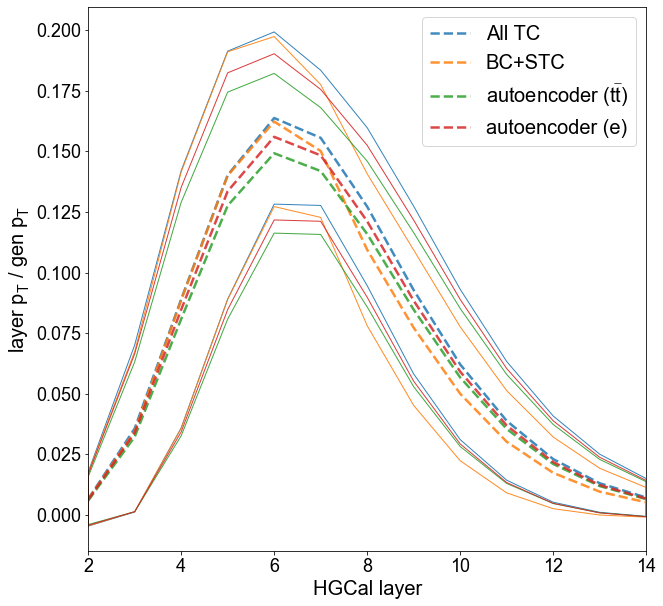

In [74]:
# make some preliminary plots showing layer-by-layer pt modeling w/o corrections

fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

layer_ix = list(range(2, 15))
layer_features = [f'cl3d_layer_{n}_pt' for n in layer_ix] # select layers [2,14] for EE
for i, (algo, df) in enumerate(dict_df_photon.items()):
    if algo == 'gen': 
        continue
    
    quality_cuts = '(matched_pid == 22) and (matched_pt > 5) and (abs(matched_dr) < 0.05)'
    df_cut = dict_df_photon[algo].query(quality_cuts)
    layer_pt = df_cut[layer_features].values
    gen_pt = df_cut['matched_pt'].values
    cl3d_pt = df_cut['cl3d_pt'].values
    layer_pt_norm = np.transpose(layer_pt.T/gen_pt)
    
    x = layer_ix
    layer_pt_mean = layer_pt_norm.mean(axis=0)
    layer_pt_err = layer_pt_norm.std(axis=0)
    ax.plot(x, layer_pt_mean, f'C{i}--', alpha=0.85)
    ax.fill_between(x, layer_pt_mean - layer_pt_err, layer_pt_mean + layer_pt_err,
                    color = f'C{i}',
                    facecolor='none',
                    #hatch='\\',
                    alpha=0.9
                   )
    ax.set_xlim(np.min(x), np.max(x)) 
    ax.set_xlabel('HGCal layer', fontsize=20)
    ax.set_ylabel('layer $p_{T}$ / gen $p_{T}$', fontsize=20)
    #print(algo, layer_pt_mean)
    ax.grid()
    
ax.legend(fancy_labels, fontsize=20)
    
plt.savefig('../plots/photon_layer_pt.pdf')
plt.show()

## Energy corrections

### Layer weights

On 0PU photon clusters:
   - Select layer pTs in the ECAL, dropping the first layer as it doesn't bring anything in the e/g energy and is polluted by PU
   - Apply linear regression to find multiplicative coeff. to be applied to each layer pT. These coeff. are bounded between 0 and 2 to avoid large correction factors

In [75]:
layer_coeffs = {}
for algo, df in dict_df_photon.items():
    if algo == 'gen': 
        continue
    
    print(algo)
    quality_cuts = '(matched_pid == 22) and (matched_pt > 5) and (abs(matched_dr) < 0.05)'
    df_photons = dict_df_photon[algo].query(quality_cuts)
    gen_pt = df_photons['matched_pt'].values
    layer_pt = df_photons[layer_features].values
    regression = lsq_linear(layer_pt, gen_pt,
                            bounds = (0.5, 1.5),
                            method='bvls',
                            lsmr_tol='auto',
                            verbose=1)
    layer_coeffs[algo] = regression.x
    print(regression.x)

Threshold0
The relative change of the cost function is less than `tol`.
Number of iterations 5, initial cost 4.2837e+05, final cost 2.2065e+05, first-order optimality 5.97e-09.
[1.5        0.90175149 1.16388522 0.96172627 0.96319076 1.17883505
 1.05016775 0.93570934 0.83714072 1.03231881 1.5        1.5
 1.5       ]
Mixedbcstc
The relative change of the cost function is less than `tol`.
Number of iterations 5, initial cost 4.2868e+05, final cost 2.6267e+05, first-order optimality 1.95e-08.
[1.5        0.98024274 1.15664009 0.95750221 1.01837349 1.5
 0.95636642 1.08899217 1.04153972 1.40319101 1.5        1.5
 1.5       ]
AutoEncoderStrideTelescope
The relative change of the cost function is less than `tol`.
Number of iterations 5, initial cost 5.8119e+05, final cost 3.7628e+05, first-order optimality 3.16e-08.
[1.5        0.99640948 1.2980766  1.10483423 1.02097431 1.24747896
 1.14563448 1.04760885 0.93285972 1.34307043 1.5        1.5
 1.5       ]
AutoEncoderStrideTelescopeEle
The relati

Apply layer weights and compute ratios wrt the gen $p_T$ and plot the weight values

In [76]:
# Apply calibration
for name, df in dict_df_electron.items():
    layers = df[layer_features].values
    df['cl3d_pt_calib_l1'] = np.dot(layers, layer_coeffs[name])
    df['pt_ratio'] = df['cl3d_pt']/df['matched_pt']
    df['pt_ratio_calib_l1'] = df['cl3d_pt_calib_l1']/df['matched_pt']

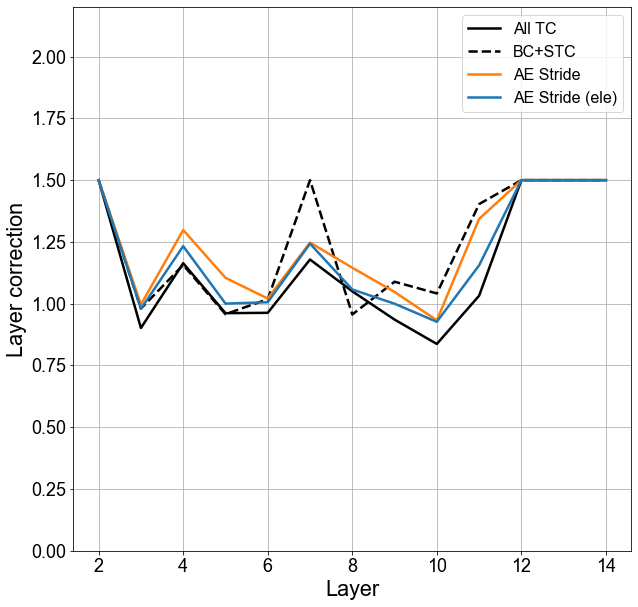

In [77]:
plt.figure(figsize=(10, 10), facecolor='white')

for name, weights in layer_coeffs.items():
    plt.plot(layer_ix, weights, label=legends[name], color=colors[name], ls=styles[name])
    
plt.ylim(0., 2.2)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('Layer')
plt.ylabel('Layer correction')
plt.savefig('../plots/photon_layer_corrections.pdf')
plt.show()

Check impact of layer corrections on the energy ratio distributions

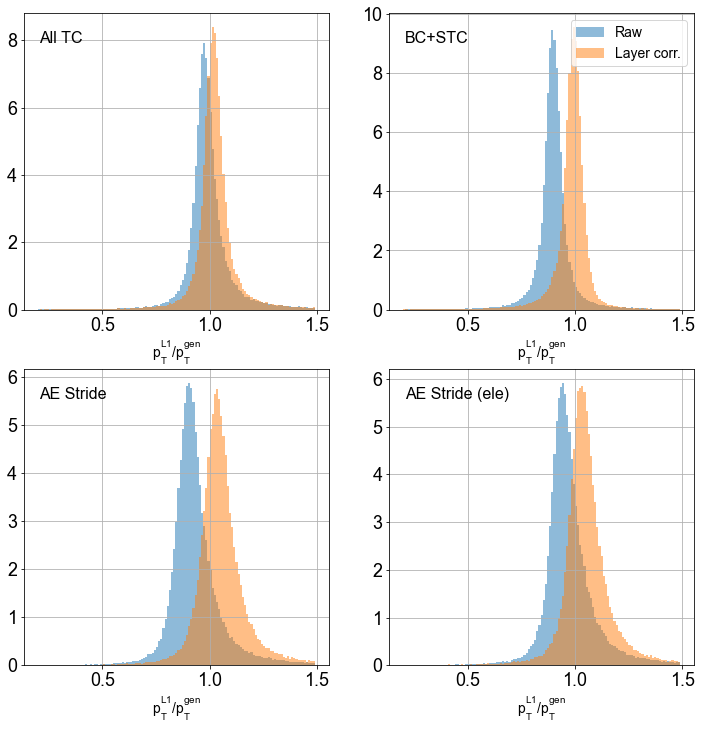

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), facecolor='white')

for ix, (name, df) in enumerate(dict_df_electron.items()):
    ax = axes[ix//2][ix%2]                     
                         
    #print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
    #    df_cut['cl3d_over_gen_pt'].mean(),
    #    df_cut['cl3d_over_gen_pt'].std(),
    #    df_cut['cl3d_over_gen_pt'].std()/df_cut['cl3d_over_gen_pt'].mean()
    #))
    #print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
    #    df_cut['calib_over_gen_pt'].mean(),
    #    df_cut['calib_over_gen_pt'].std(),
    #    df_cut['calib_over_gen_pt'].std()/df_cut['calib_over_gen_pt'].mean()
    #))
    
    df_cut = df.query('abs(matched_pid) == 11')
    ax.hist(df_cut['pt_ratio'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Raw', density=True)
    ax.hist(df_cut['pt_ratio_calib_l1'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Layer corr.', density=True)
    ax.text(0.05, 0.9, legends[name], fontsize=16, transform=ax.transAxes)
    ax.grid()
    
    if ix == 1:
        ax.legend(fontsize=14, loc=1)
        
    ax.set_xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$', fontsize=14)
    
#plt.set_tightlayout()r_c
plt.savefig('../plots/pt_ratio_layer_corr.pdf')
plt.show()

## eta correction
On 200PU electrons, on top of the layer correction.

Simple linear correction vs eta to correct for PU. This correction is additive, not multiplicative.

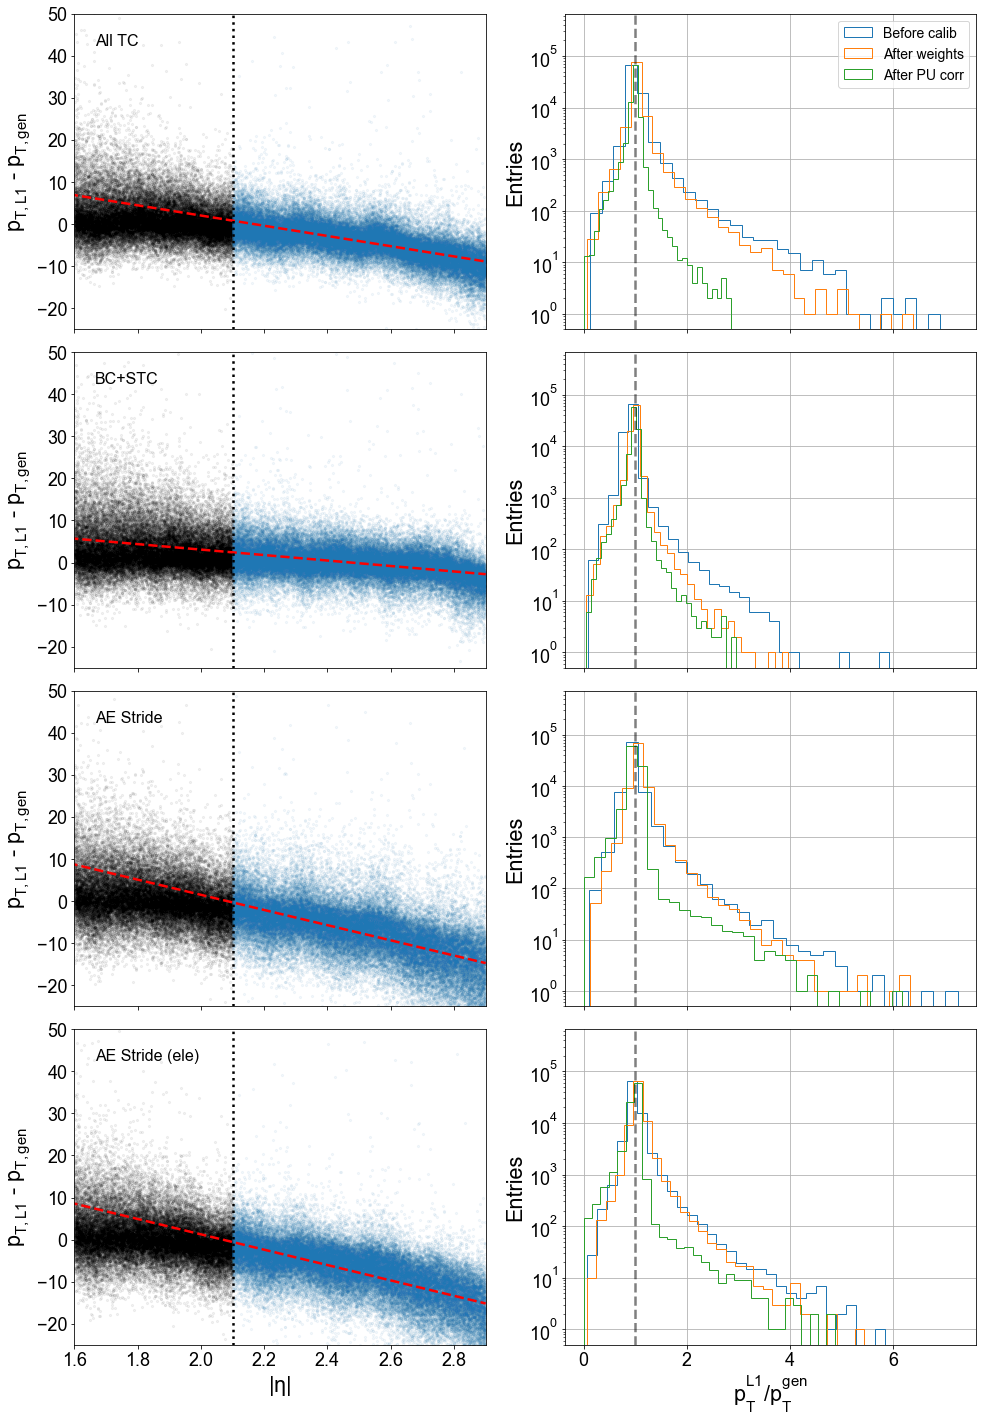

In [79]:
eta_corrs = {}
fig, axes = plt.subplots(4, 2, figsize=(14, 20), facecolor='white', sharex='col')
for ix, (name, df) in enumerate(dict_df_electron.items()):
    ax = axes[ix][0]
    
    # calculate eta corrections
    df_cut = df.query('(abs(matched_pid) == 11) and (matched_pt > 5) and (abs(matched_dr) < 0.05)')
    df_anticut = df.query('abs(cl3d_eta) < 2.1')
    df_cut = df_cut.query('abs(cl3d_eta) > 2.1')
    X = abs(df_cut['cl3d_eta'].values)
    y = df_cut['matched_pt'] - df_cut['cl3d_pt_calib_l1']
    corrs = LinearRegression().fit(X.reshape(-1, 1), y)
    eta_corrs[name] = corrs
    
    # plot the data used to derive corrections and the fit result
    x = np.linspace(1.5, 2.9, 100)
    X_anticut = abs(df_anticut['cl3d_eta'].values)
    y_anticut = df_anticut['matched_pt'] - df_anticut['cl3d_pt_calib_l1']
    ax.scatter(X_anticut, y_anticut, alpha=0.05, s=5, c='k')
    ax.scatter(X, y, alpha=0.05, s=5)
    ax.plot(x, corrs.predict(x.reshape(-1, 1)), 'r--')
    ax.plot([2.1, 2.1], [-25, 50], 'k:')
    ax.text(0.05, 0.9, legends[name], fontsize=16, transform=ax.transAxes)
    ax.set_ylim(-25, 50)
    ax.set_xlim(1.6, 2.9)
    ax.set_ylabel(r'$p_{T, L1}$ - $p_{T, gen}$')
    
    if ix == 3:
        ax.set_xlabel(r'$|\eta|$')
    
    #print(name)
    #print(f'eta = 1.5: {corr.intercept_ + corr.coef_*1.5}')
    #print(f'eta = 3: {corr.intercept_ + corr.coef_*3}')

    # apply the correction
    df['cl3d_corr_eta'] = corrs.predict(abs(df[['cl3d_eta']]))
    mask = (df['cl3d_corr_eta'] > 0.) | (df['cl3d_pt_calib_l1'] < abs(df['cl3d_corr_eta']))
    df.loc[mask, 'cl3d_corr_eta'] = 0.
    df['cl3d_pt_calib_l2'] =  df['cl3d_pt_calib_l1'] + df['cl3d_corr_eta']
    df['pt_ratio_calib_l2'] = df['cl3d_pt_calib_l2'] / df['matched_pt']    

    #df_cut = df.query('matched_pid == 22 and matched_pt > 10')
    
    ax = axes[ix][1]
    h, b, _ = ax.hist(df['pt_ratio'], bins=30, histtype='step', label='Before calib')
    ax.hist(df['pt_ratio_calib_l1'], bins=30, histtype='step', label='After weights')
    ax.hist(df['pt_ratio_calib_l2'], bins=30, histtype='step', label='After PU corr')
    ax.plot([1, 1], [0.5, 10*h.max()], 'k--', alpha=0.5)
    ax.set_ylim(0.5, 10*h.max())
    ax.set_yscale('log')
    ax.set_ylabel('Entries')
    ax.grid()
    #ax.text(name, font)
    
    if ix == 0:
        ax.legend(loc = 'upper right', fontsize=14)
    
    if ix == 3:
        ax.set_xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
        
plt.tight_layout()
plt.savefig('../plots/pileup_correction_eta.pdf')
plt.show()

## Final plots
For electrons with 200PU, looking at $p_T > 10\,GeV$
First bin in eta and pT

In [80]:
binetasize = 0.2
binptsize = 10 
etamin = 1.6
for name, df in dict_df_electron.items():
    df['genpart_abseta'] = np.abs(df.cl3d_eta)
    df['eta_bin'] = ((df['genpart_abseta'] - etamin)//binetasize).astype('int32')
    df['pt_bin'] = (df['matched_pt'] // binptsize).astype('int32')

Compute the mean, RMS, and effective RMS of the pT ratios in each eta and pT bin

In [81]:
def central_ci(df, cl=0.68):
    # computes the central confidence level (cl) for each input array
    
    out = {}
    for col in df:
        x = df[col]
        x = np.sort(x, kind="mergesort")
        m = int(cl * len(x)) + 1
        out[col] = [np.min(x[m:] - x[:-m]) / 2.0]
        
    return pd.DataFrame(out).iloc[0]

In [82]:
subplot_layout = '''
AAABC
AAABC
AAABC
DDD..
EEE..
'''

#axd = plt.figure(constrained_layout=True).subplot_mosaic(subplot_layout)

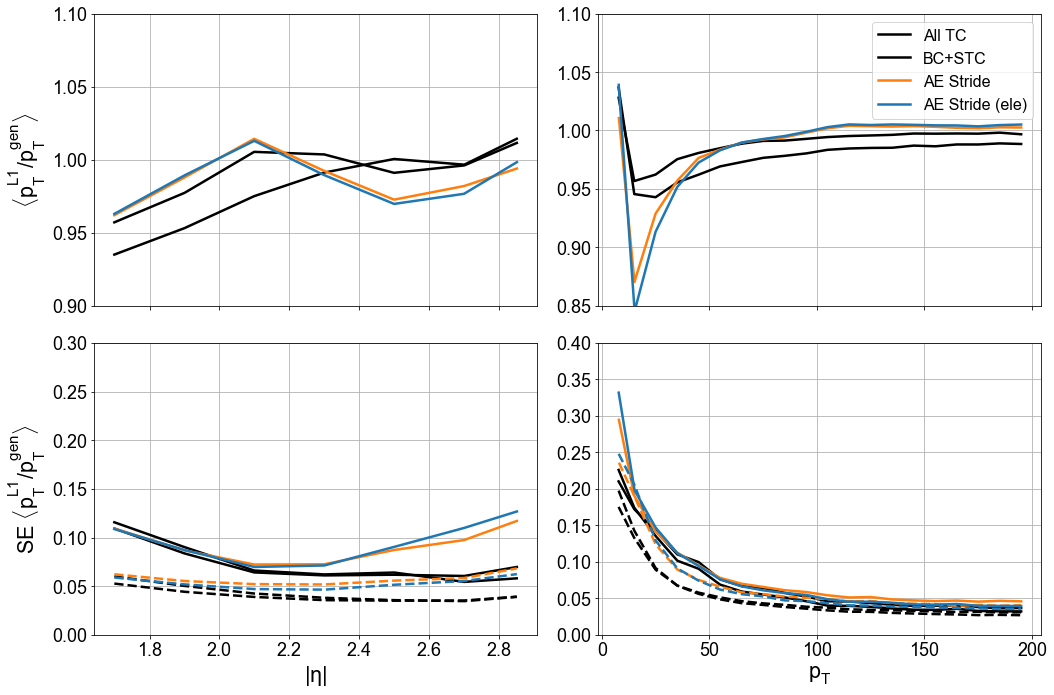

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), facecolor='white', sharex='col')
for algo, df_algo in dict_df_electron.items():
    df = df_algo.query('(cl3d_pt_calib_l2 > 5) and (matched_pt > 5)')
    #print(df_mean['genpart_abseta'])
    
    ax = axes[0][0]
    gr_eta = df.groupby('eta_bin')
    df_mean = gr_eta.mean()
    ax.plot(df_mean['genpart_abseta'], df_mean['pt_ratio_calib_l2'], 
            color=colors[algo],
            ls='-', 
            label=legends[algo]
           )
    
    ax = axes[1][0]
    df_std = gr_eta.std()
    ax.plot(df_mean['genpart_abseta'], df_std['pt_ratio_calib_l2'], 
            color=colors[algo], 
            ls='-',
            label=legends[algo]
           )
    
    df_ci = gr_eta.apply(central_ci)
    ax.plot(df_mean['genpart_abseta'], df_ci['pt_ratio_calib_l2'], 
            color=colors[algo], 
            ls='--', 
            label=legends[algo]
           )
    
    ax = axes[0][1]
    gr_pt = df.groupby('pt_bin')
    df_mean = gr_pt.mean()
    ax.plot(df_mean['matched_pt'], df_mean['pt_ratio_calib_l2'], 
            color=colors[algo],
            ls='-', 
            label=legends[algo]
           )
    
    ax = axes[1][1]
    df_std = gr_pt.std()
    ax.plot(df_mean['matched_pt'], df_std['pt_ratio_calib_l2'], 
            color=colors[algo], 
            ls='-',
            label=legends[algo]
           )
    
    df_ci = gr_pt.apply(central_ci)
    ax.plot(df_mean['matched_pt'], df_ci['pt_ratio_calib_l2'], 
            color=colors[algo], 
            ls='--', 
            label=legends[algo]
           )
    
    
    
ax = axes[0][0]
ax.set_ylim(0.9, 1.1)
ax.set_ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
ax.grid()

ax = axes[1][0]
ax.set_ylim(0., 0.3)
ax.set_xlabel(r'$|\eta|$')
ax.set_ylabel(r'SE $\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
ax.grid()

ax = axes[0][1]
ax.set_ylim(0.85, 1.1)
ax.legend(loc = 'upper right', fontsize=16)
ax.grid()

ax = axes[1][1]
ax.set_ylim(0., 0.4)
ax.set_xlabel(r'$p_{T}$')
ax.grid()

plt.tight_layout()
plt.savefig('../plots/pt_ratio_eta.pdf')
plt.show()

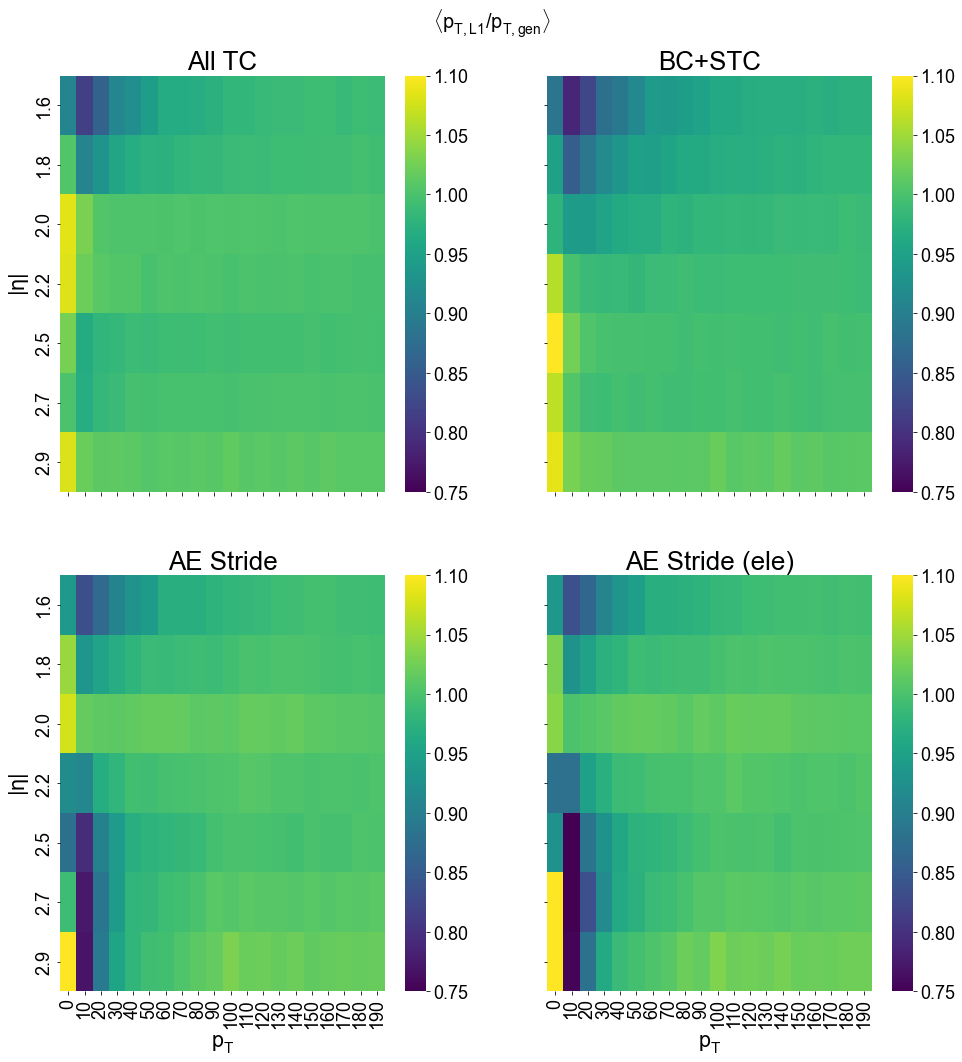

In [84]:
import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize=(16, 16), facecolor='white', sharex=True, sharey=True)
fig.suptitle(r'$\langle p_{T,L1}/p_{T,gen}\rangle$', fontsize=20)

# calculate pt ratio and 68% CI
eta_bins = [f'{neta:0.1f}' for neta in np.linspace(eta_min, eta_max, 7)]
pt_bins = np.linspace(0., 190, 20).astype(int)
for ix, (algo, df_algo) in enumerate(dict_df_electron.items()):
    
    ax = axes[ix//2][ix%2]
    df = df_algo.query('(cl3d_pt_calib_l2 > 5) and (matched_pt > 5)')
    df = df.groupby(['pt_bin', 'eta_bin']).mean()
    df = df.reset_index().pivot(columns='pt_bin', index='eta_bin', values='pt_ratio_calib_l2')
    sns.heatmap(df, ax=ax, cmap='viridis', 
                xticklabels=pt_bins,
                yticklabels=eta_bins,
                vmin=0.75, 
                vmax=1.1, 
                #cbar=bool(ix%2)
               )
    ax.set_title(legends[algo])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation=0)
    
    if ix%2 == 0:
        ax.set_ylabel('$|\eta|$')
    
    if ix//2 > 0:
        ax.set_xlabel(r'$p_{T}$')

plt.savefig('../plots/pt_mean_pt_eta.pdf')
fig.subplots_adjust(top=0.92)
plt.show()

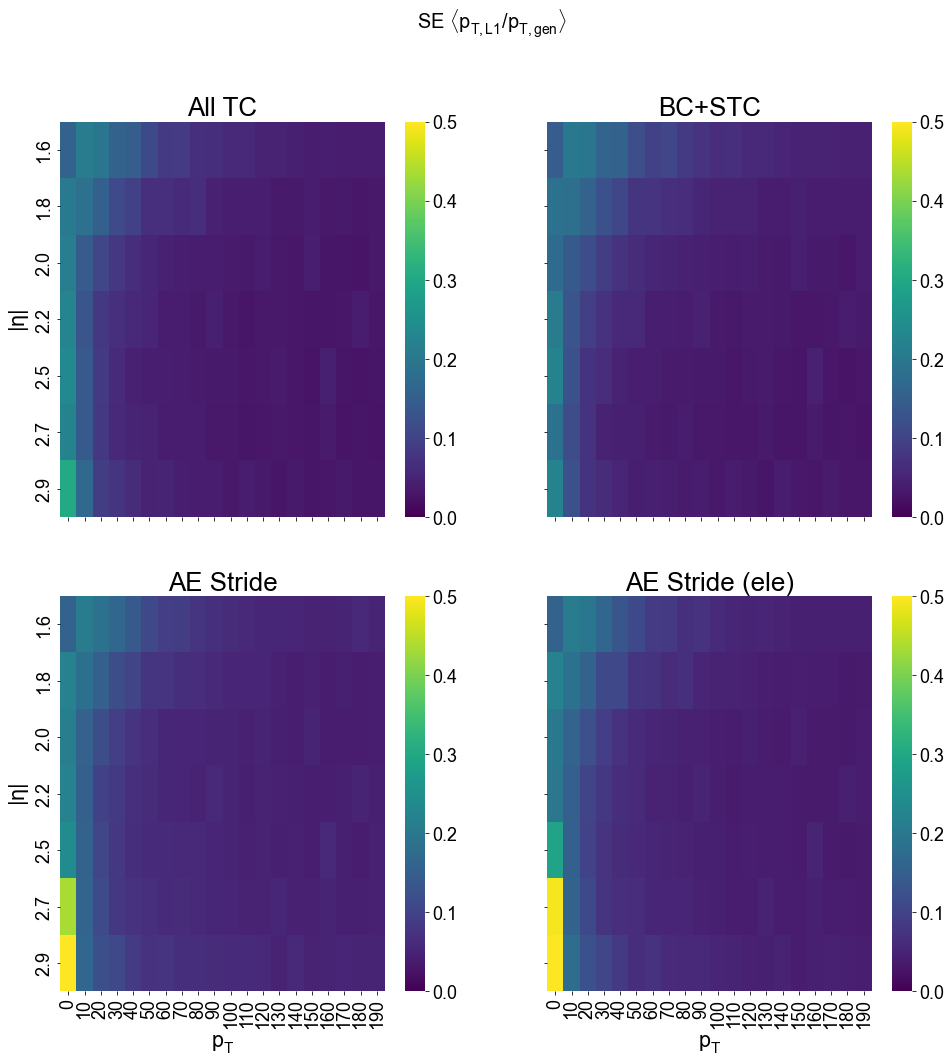

In [85]:
import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize=(16, 16), facecolor='white', sharex=True, sharey=True)
fig.suptitle(r'SE $\langle p_{T,L1}/p_{T,gen}\rangle$', fontsize=20)

# calculate pt ratio and 68% CI
eta_bins = [f'{neta:0.1f}' for neta in np.linspace(eta_min, eta_max, 7)]
pt_bins = np.linspace(0., 190, 20).astype(int)
for ix, (algo, df_algo) in enumerate(dict_df_electron.items()):
    
    ax = axes[ix//2][ix%2]
    df = df_algo.query('(cl3d_pt_calib_l2 > 5) and (matched_pt > 5)')
    df = df.groupby(['pt_bin', 'eta_bin']).std()
    df = df.reset_index().pivot(columns='pt_bin', index='eta_bin', values='pt_ratio_calib_l2')
    sns.heatmap(df, ax=ax, cmap='viridis', 
                xticklabels=pt_bins,
                yticklabels=eta_bins,
                vmin=0., 
                vmax=0.5, 
                #cbar=bool(ix%2)
               )
    ax.set_title(legends[algo])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.yticks(rotation=0)
    
    if ix%2 == 0:
        ax.set_ylabel('$|\eta|$')
    
    if ix//2 > 0:
        ax.set_xlabel(r'$p_{T}$')

plt.savefig('../plots/pt_err_pt_eta.pdf')
plt.show()

## Storing layer weights and eta corrections for external use

In [86]:
with open(f'../data/layer_weights_photons_autoencoder_{version}.pkl', 'wb') as f:
    pickle.dump(layer_coeffs, f)
    # add  protocol=2 if needed later for python2 in cmssw
with open(f'data/lineareta_electrons_autoencoder_{version}.pkl', 'wb') as f:
    pickle.dump(corrs['eta'], f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/lineareta_electrons_autoencoder_updated.pkl'

In [ ]:
%pwd